## Imports

In [229]:
import pandas as pd
import re
import timeit
import seaborn as sns
#import lightgbm as lgb
import numpy as np
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import sklearn.metrics as sm
from sklearn.ensemble import IsolationForest
import plotly.express as px
import numpy as np
import warnings
import datetime
import xgboost as xgb
import math
import joblib
import matplotlib.pyplot as plt
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingGridSearchCV
import tsaug
from tsaug.visualization import plot
import smogn

warnings.filterwarnings("ignore")

#Imports TFG Original
from prettytable import PrettyTable
from os import listdir
from os.path import isfile, join
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score , mean_squared_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from yellowbrick.model_selection import FeatureImportances
from sklearn.linear_model import LinearRegression



## Funció Alineament de Dades

In [105]:
def alignSeries(serie, lag):
    minutesRow = 30
    posToMove = int(lag / minutesRow)  
    outputSerie = serie['data'].to_numpy()
    size = len(outputSerie)
    outputSerie = np.pad(outputSerie, (posToMove,0), 'constant', constant_values=(0))
    outputSerie = outputSerie[:size]
    return outputSerie

## Carregar Dades

In [106]:
def prepareDFMod(df, col):
    output = df[[col]]
    output.rename(columns={col:'data'}, inplace=True)
    return output
    

In [107]:
# Carregar dades pluja
def loadDataPrecipitacions():
    precipitacions = pd.read_excel("finalsDF/DF_SMC.xlsx", index_col=0)
    return precipitacions

In [108]:
# Carregar dades Alt Ter
def loadDataTer(nom, Ter):
    
    altTer = prepareDFMod(Ter, nom)
    
    return altTer

In [109]:
#Carregar dades precipitacions Alt Ter:
def loadDataPrecipitacions(nom, precipitacions):
    
    #Carregar dades
    precipitacions = prepareDFMod(precipitacions, nom)
    
    #Moving Average
    precipitacions['data'] = precipitacions['data'].rolling(window=5).mean()
    precipitacions['data'] = precipitacions['data'].rolling(window=5).mean()
    
    return precipitacions

In [110]:
altTer = pd.read_excel("Dataframes/df_imputedAltTerKNN.xlsx", index_col=0)
baixTer = pd.read_excel("Dataframes/df_imputedBaixTerKNN.xlsx", index_col=0)
precipitacions = pd.read_csv("finalsDF/DF_SMC.csv", index_col=0)

# Alineament del DataFrame amb Referencia (Alt Ter)

In [111]:
idx = pd.date_range("2009-01-01", periods=210386, freq="30T")

In [112]:
ts = pd.Series(range(len(idx)), index=range(len(idx)))

In [113]:
#Carregar Dades Comparatives

#Alinear Ripoll
ripoll = loadDataTer("L17147-72-00005", altTer)
ripoll = alignSeries(ripoll, 150)

#Alinear Sant Joan
santJoan = loadDataTer("L17167-72-00001", altTer)
santJoan = alignSeries(santJoan, 180)

#Alinear DG
DG = loadDataPrecipitacions("DG", precipitacions)
DG = alignSeries(DG, 270)

#Alinear CG 
CG = loadDataPrecipitacions("CG", precipitacions)
CG = alignSeries(CG, 300)

#Alinear CI
CI = loadDataPrecipitacions("CI", precipitacions)
CI = alignSeries(CI, 150)

#Alinear V4
V4 = loadDataPrecipitacions("V4", precipitacions)
V4 = alignSeries(V4, 180)

#Alinear CC
CC = loadDataPrecipitacions("CC", precipitacions)
CC = alignSeries(CC, 195)

#Alinear CY
CY = loadDataPrecipitacions("CY", precipitacions)
CY = alignSeries(CY, 240)

#Alinear VN
VN = loadDataPrecipitacions("VN", precipitacions)
VN = alignSeries(VN, 300)

#Alinear WS
WS = loadDataPrecipitacions("WS", precipitacions)
WS = alignSeries(WS, 300)

#Alinear V3

V3 = loadDataPrecipitacions("V3", precipitacions)
V3 = alignSeries(V3, 210)

#Z4_ZC

In [114]:
#Creem el DataFrame amb les dades alineades i el guardem 
dfAltX = pd.DataFrame(index=range(len(idx)))
dfAltX["L17147-72-00005"] = pd.Series(ripoll.tolist())
dfAltX["L17167-72-00001"] = pd.Series(santJoan.tolist())
dfAltX['DG'] = pd.Series(DG.tolist())
dfAltX['CG'] = pd.Series(CG.tolist())
dfAltX['CI'] = pd.Series(CI.tolist())
dfAltX['V4'] = pd.Series(V4.tolist())
dfAltX['CC'] = pd.Series(CC.tolist())
dfAltX['CY'] = pd.Series(CY.tolist())
dfAltX['VN'] = pd.Series(VN.tolist())
dfAltX['WS'] = pd.Series(WS.tolist())
dfAltX['V3'] = pd.Series(V3.tolist())



In [115]:
#Assignem les hores al index
dfAltX['datetime'] = pd.date_range("2009-01-01", periods=210386, freq="30T")
dfAltX.set_index('datetime', drop=True, inplace=True)

#Eliminem del top el maxim de posicions que hem alineat (en aquest cas 300)

minutesRow = 30
lag = 300
posToMove = int(lag / minutesRow)
dfAltX.drop(dfAltX.head(posToMove).index, inplace=True)
dfAltX.drop(dfAltX.tail(1).index, inplace=True)
dfAltX.fillna(0, inplace=True)


In [116]:
#Eliminem les mateixes columnes del 
masies = loadDataTer("L08116-72-00002", altTer)
masies.rename(columns={'data':'L08116-72-00002'}, inplace=True)
minutesRow = 30
lag = 300
posToMove = int(lag / minutesRow)
masies.drop(masies.head(posToMove).index, inplace=True)
dfAltY = masies
dfAltX.fillna(0, inplace=True)
dfAltY.fillna(0, inplace=True)

In [117]:
#Guardem el matrix de X y el array de y en un csv

dfAltX.to_csv('dfAltX.csv')
dfAltY.to_csv('dfAltY.csv')

# Alineament del DataFrame amb Referencia (Baix Ter)

In [118]:
idx = pd.date_range("2009-01-01", periods=210386, freq="30T")

In [119]:
ts = pd.Series(range(len(idx)), index=range(len(idx)))

In [120]:
#Carregar Dades Comparatives

#Alinear L17199-72-00001

L171997200001 = loadDataTer("L17199-72-00001", baixTer)
L171997200001 = alignSeries(L171997200001, 300)

#Alinear F026458

F026458 = loadDataTer("F026458", baixTer)
F026458 = alignSeries(F026458, 300)

#Alinear F001242
F001242 = loadDataTer("F001242", baixTer)
F001242 = alignSeries(F001242, 300)

#Alinear L170797200005
L170797200005 = loadDataTer("L17079-72-00005", baixTer)
L170797200005 = alignSeries(L170797200005, 270)

#Alinear L17079-72-00004

L170797200004 = loadDataTer("L17079-72-00004", baixTer)
L170797200004 = alignSeries(L170797200004, 270)

#Alinear L17038-72-00002

L170387200002 = loadDataPrecipitacions("L17038-72-00002", baixTer)
L170387200002 = alignSeries(L170387200002, 270)

#Alinear KE
KE = loadDataPrecipitacions("KE", precipitacions)
KE = alignSeries(KE, 300)

#Alinear UO
UO = loadDataPrecipitacions("UO", precipitacions)
UO = alignSeries(UO, 480)

#Alinear UN
UN = loadDataPrecipitacions("UN", precipitacions)
UN = alignSeries(UN, 405)

#Alinear WS
WS = loadDataPrecipitacions("WS", precipitacions)
WS = alignSeries(WS, 270)

#Alinear DJ

DJ = loadDataPrecipitacions("DJ", precipitacions)
DJ = alignSeries(DJ, 360)



In [121]:
#Creem el DataFrame amb les dades alineades i el guardem 
dfBaixX = pd.DataFrame(index=range(len(idx)))
dfBaixX["L17199-72-00001"] = pd.Series(L171997200001.tolist())
dfBaixX["F026458"] = pd.Series(F026458.tolist())
dfBaixX['F001242'] = pd.Series(F001242.tolist())
dfBaixX['L17079-72-00005'] = pd.Series(L170797200005.tolist())
dfBaixX['L17079-72-00004'] = pd.Series(L170797200004.tolist())
dfBaixX['L17038-72-00002'] = pd.Series(L170387200002.tolist())
dfBaixX['KE'] = pd.Series(KE.tolist())
dfBaixX['UO'] = pd.Series(UO.tolist())
dfBaixX['UN'] = pd.Series(UN.tolist())
dfBaixX['WS'] = pd.Series(WS.tolist())
dfBaixX['DJ'] = pd.Series(DJ.tolist())




In [122]:
#Assignem les hores al index
dfBaixX['datetime'] = pd.date_range("2009-01-01", periods=210386, freq="30T")
dfBaixX.set_index('datetime', drop=True, inplace=True)

#Eliminem del top el maxim de posicions que hem alineat (en aquest cas 300)

minutesRow = 30
lag = 300
posToMove = int(lag / minutesRow)
dfBaixX.drop(dfBaixX.head(posToMove).index, inplace=True)
dfBaixX.drop(dfBaixX.tail(1).index, inplace=True)
dfBaixX.fillna(0, inplace=True)

In [123]:
#Eliminem les mateixes columnes del 
colomers = loadDataTer("L17055-72-00002", baixTer)
colomers.rename(columns={'data':'L17055-72-00002'}, inplace=True)
minutesRow = 30
lag = 300
posToMove = int(lag / minutesRow)
colomers.drop(colomers.head(posToMove).index, inplace=True)
dfBaixY = colomers
dfBaixX.fillna(0, inplace=True)
dfBaixY.fillna(0, inplace=True)

In [124]:
#Guardem el matrix de X y el array de y en un csv

dfBaixX.to_csv('dfBaixX.csv')
dfBaixY.to_csv('dfBaixY.csv')

In [223]:
import site
site.getsitepackages()

['/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages']

# Pre-processament de Dades (Data Augmentation, Splits, etc...)

## Train Only Events

In [285]:
#Carregar del csv
Df_AltX = pd.read_csv('dfAltX.csv')
Df_Alty = pd.read_csv('dfAltY.csv')
Df_BaixX = pd.read_csv('dfBaixX.csv')
Df_Baixy = pd.read_csv('dfBaixY.csv')

# Fiquem el datetime com a index
Df_Alty = Df_Alty.set_index('DATA')
Df_AltX = Df_AltX.set_index('datetime')
Df_Baixy = Df_Baixy.set_index('DATA')
Df_BaixX = Df_BaixX.set_index('datetime')



In [286]:
#Visualització de la distribució del plot per comprovar a partir de quin threshold de pluja tallar
#Alt Ter
Df_AltX['Pluja'] = Df_AltX[['DG','CG','CI','V4','CC','CY','VN','WS','V3']].mean(axis=1)
print(Df_AltX['Pluja'].shape)
Df_AltX = Df_AltX.loc[Df_AltX['Pluja'] > 0.5]
print(Df_AltX['Pluja'].shape)
Df_AltX.drop(columns=['Pluja'],inplace=True)
Df_Alty = Df_Alty.loc[np.intersect1d(Df_AltX.index, Df_Alty.index)]


#Baix Ter
Df_BaixX['Pluja'] = Df_BaixX[['KE','UO','UN','WS','DJ']].mean(axis=1)
print(Df_BaixX['Pluja'].shape)
Df_BaixX = Df_BaixX.loc[Df_BaixX['Pluja'] > 0.5]
print(Df_BaixX['Pluja'].shape)
Df_BaixX.drop(columns=['Pluja'],inplace=True)
Df_Baixy = Df_Baixy.loc[np.intersect1d(Df_BaixX.index, Df_Baixy.index)]




(210375,)
(6205,)
(210375,)
(5667,)


In [287]:
Df_AltX.to_csv('dfAltXAnomalies.csv')
Df_Alty.to_csv('dfAltYAnomalies.csv')
Df_BaixX.to_csv('dfBaixXAnomalies.csv')
Df_Baixy.to_csv('dfBaixYAnomalies.csv')

## Train Only Events (with SMOTE / SMOGN)

In [303]:
#Carreguem les dades i les agrupem per utilitzar SMOGN
Df_AltX = pd.read_csv('dfAltXAnomalies.csv')
Df_Alty = pd.read_csv('dfAltYAnomalies.csv')
Df_BaixX = pd.read_csv('dfBaixXAnomalies.csv')
Df_Baixy = pd.read_csv('dfBaixYAnomalies.csv')

Df_AltX.drop('datetime',inplace=True, axis=1)
Df_Alty.drop('DATA', inplace=True, axis=1)
Df_BaixX.drop('datetime', inplace=True, axis=1)
Df_Baixy.drop('DATA', inplace=True, axis=1)

Df_AltX['L08116-72-00002'] = Df_Alty['L08116-72-00002']
Df_BaixX['L17055-72-00002'] = Df_Baixy['L17055-72-00002']


In [304]:
#SMOGN Alt Ter
print('Dimensions pre-SMOGN: ', Df_AltX.shape)
Df_AltX_Smogn = smogn.smoter(
    
    ## main arguments
    data = Df_AltX,           ## pandas dataframe
    y = 'L08116-72-00002',    ## string ('header name')
    k = 5,                    ## positive integer (k < n)
    samp_method = 'extreme',  ## string ('balance' or 'extreme')
)
print('Dimensions post-SMOGN: ', Df_AltX_Smogn.shape)



Dimensions pre-SMOGN:  (6205, 12)


r_index: 100%|############################| 1039/1039 [00:00<00:00, 2140.45it/s]

Dimensions post-SMOGN:  (8371, 12)


In [305]:
#SMOGN Baix Ter
print('Dimensions pre-SMOGN: ', Df_BaixX.shape)
Df_BaixX_Smogn = smogn.smoter(
    
    ## main arguments
    data = Df_BaixX,           ## pandas dataframe
    y = 'L17055-72-00002',    ## string ('header name')
    k = 5,                    ## positive integer (k < n)
    samp_method = 'extreme',  ## string ('balance' or 'extreme')
)
print('Dimensions post-SMOGN: ', Df_BaixX_Smogn.shape)

Dimensions pre-SMOGN:  (5667, 12)


r_index: 100%|##############################| 514/514 [00:00<00:00, 2121.68it/s]

Dimensions post-SMOGN:  (7441, 12)


In [306]:
Df_AltX_Smogn = Df_AltX_Smogn.reset_index(drop=True)
Df_BaixX_Smogn = Df_BaixX_Smogn.reset_index(drop=True)

<AxesSubplot:xlabel='L08116-72-00002', ylabel='Density'>

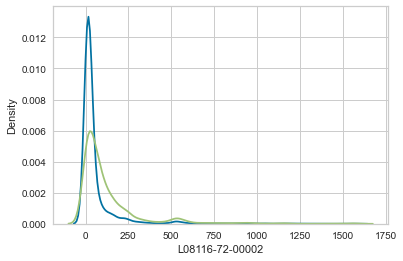

In [307]:
#Canvi distribucio
sns.kdeplot(Df_AltX['L08116-72-00002'], label='Original')
sns.kdeplot(Df_AltX_Smogn['L08116-72-00002'], label='Modificat')

<AxesSubplot:xlabel='L17055-72-00002', ylabel='Density'>

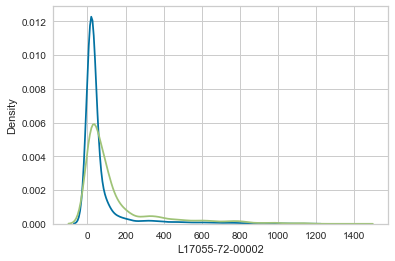

In [308]:
#Canvi distribucio
sns.kdeplot(Df_BaixX['L17055-72-00002'], label='Original')
sns.kdeplot(Df_BaixX_Smogn['L17055-72-00002'], label='Modificat')

In [309]:
Df_Alty['L08116-72-00002'] = Df_AltX_Smogn['L08116-72-00002']
Df_AltX = Df_AltX_Smogn.drop(columns=['L08116-72-00002'])
Df_Baixy['L17055-72-00002'] = Df_BaixX_Smogn['L17055-72-00002']
Df_BaixX = Df_BaixX_Smogn.drop(columns=['L17055-72-00002'])

In [310]:
Df_AltX.to_csv('dfAltXSMOGN.csv',index=False)
Df_Alty.to_csv('dfAltYSMOGN.csv',index=False)
Df_BaixX.to_csv('dfBaixXSMOGN.csv',index=False)
Df_Baixy.to_csv('dfBaixYSMOGN.csv',index=False)

## Data Augmentation (Adding Noise)

In [2]:
#Carregar del csv
Df_AltX = pd.read_csv('dfAltX.csv')
Df_Alty = pd.read_csv('dfAltY.csv')
Df_BaixX = pd.read_csv('dfBaixX.csv')
Df_Baixy = pd.read_csv('dfBaixY.csv')

In [3]:
Df_AltX.set_index('datetime', drop=True, inplace=True)
Df_BaixX.set_index('datetime', drop=True, inplace=True)

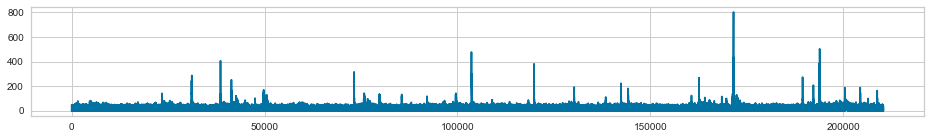

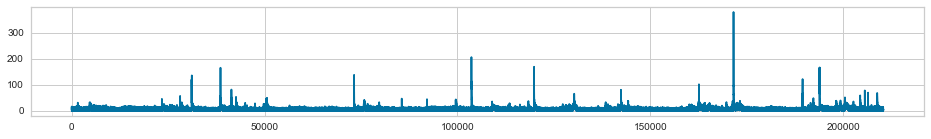

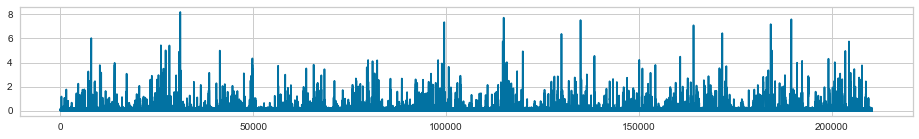

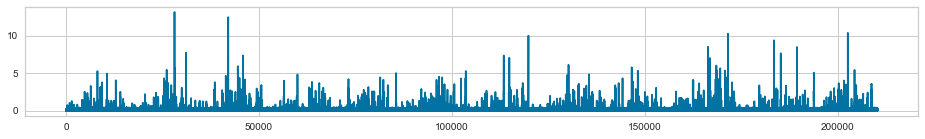

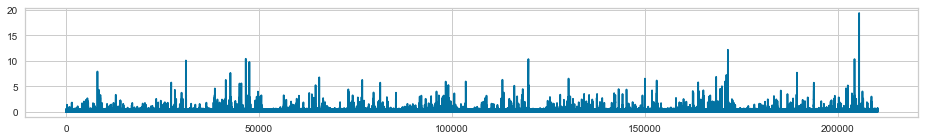

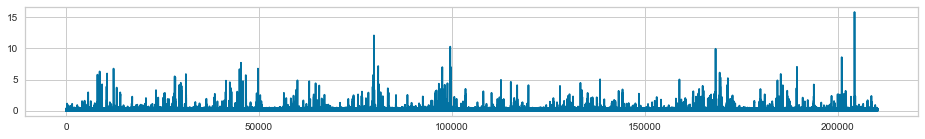

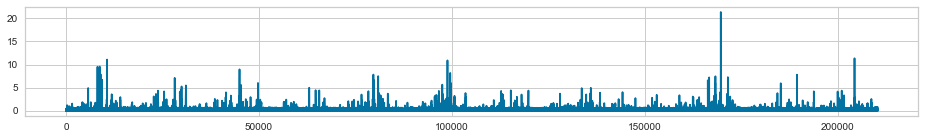

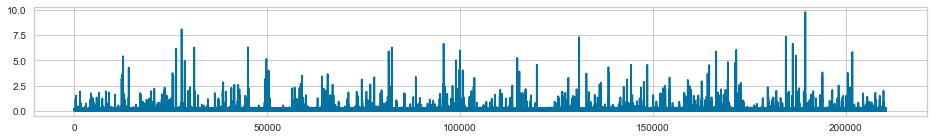

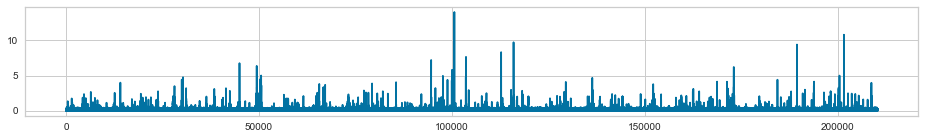

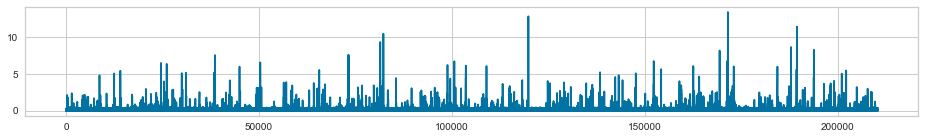

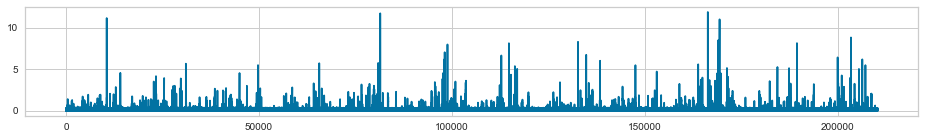

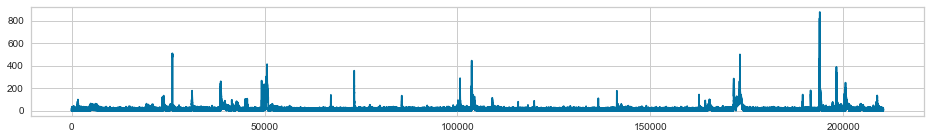

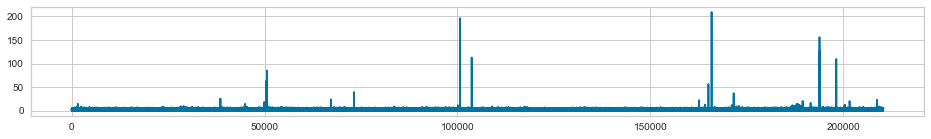

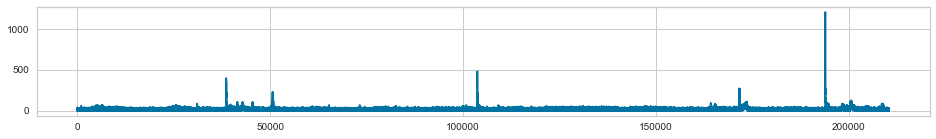

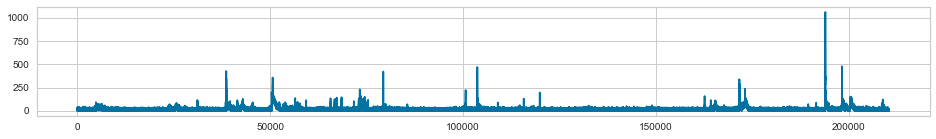

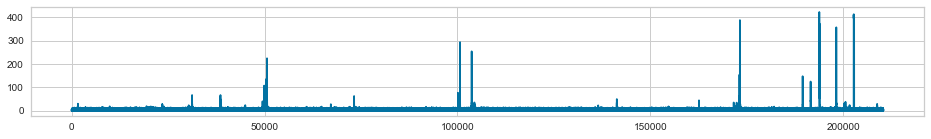

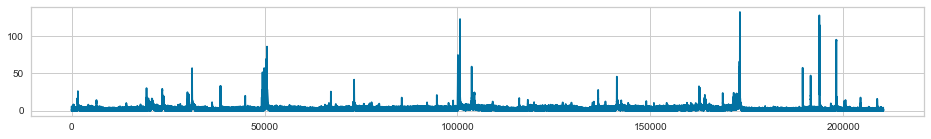

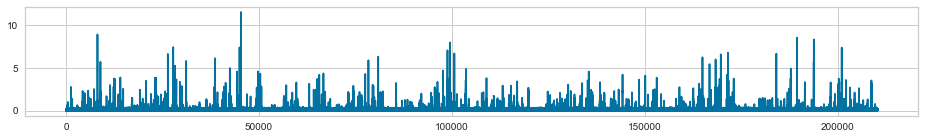

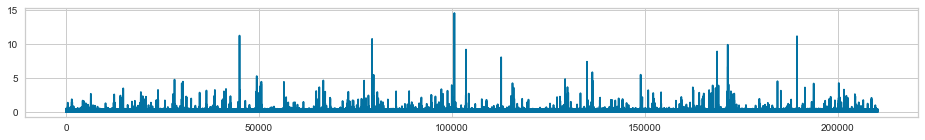

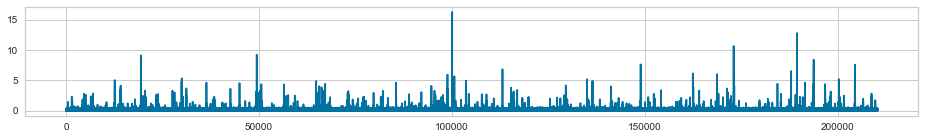

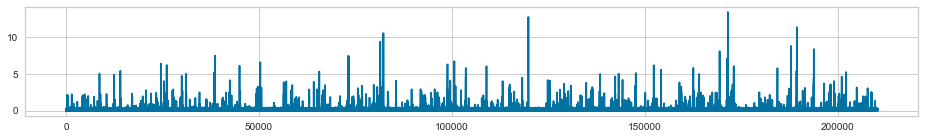

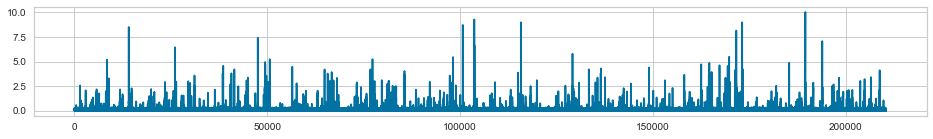

In [8]:
def addNoiseTimeSeries(df, scale=0.01):
    for column in df:
        array = df[column].to_numpy()
        aug = abs(tsaug.AddNoise(scale=scale).augment(array))
        df[column] = aug
        plot(aug)

addNoiseTimeSeries(Df_AltX)
addNoiseTimeSeries(Df_BaixX)


In [11]:
Df_AltX.to_csv('dfAltXNoise.csv')
Df_BaixX.to_csv('dfBaixXNoise.csv')

# Seleccionar DataSet

In [311]:
def datasetAlignNormal():
    Df_AltX = pd.read_csv('dfAltX.csv')
    Df_Alty = pd.read_csv('dfAltY.csv')
    Df_BaixX = pd.read_csv('dfBaixX.csv')
    Df_Baixy = pd.read_csv('dfBaixY.csv')
    Df_AltX.set_index('datetime', drop=True, inplace=True)
    Df_Alty.set_index('DATA', drop=True, inplace=True)
    Df_BaixX.set_index('datetime', drop=True, inplace=True)
    Df_Baixy.set_index('DATA', drop=True, inplace=True)
    
    return Df_AltX, Df_Alty, Df_BaixX, Df_Baixy

def datasetAlignAnomalies():
    Df_AltX = pd.read_csv('dfAltXAnomalies.csv')
    Df_Alty = pd.read_csv('dfAltYAnomalies.csv')
    Df_BaixX = pd.read_csv('dfBaixXAnomalies.csv')
    Df_Baixy = pd.read_csv('dfBaixYAnomalies.csv')
    Df_AltX.set_index('datetime', drop=True, inplace=True)
    Df_Alty.set_index('DATA', drop=True, inplace=True)
    Df_BaixX.set_index('datetime', drop=True, inplace=True)
    Df_Baixy.set_index('DATA', drop=True, inplace=True)
    
    return Df_AltX, Df_Alty, Df_BaixX, Df_Baixy

def datasetAlignNoise():
    Df_AltX = pd.read_csv('dfAltXNoise.csv')
    Df_Alty = pd.read_csv('dfAltY.csv')
    Df_BaixX = pd.read_csv('dfBaixXNoise.csv')
    Df_Baixy = pd.read_csv('dfBaixY.csv')
    Df_AltX.set_index('datetime', drop=True, inplace=True)
    Df_Alty.set_index('DATA', drop=True, inplace=True)
    Df_BaixX.set_index('datetime', drop=True, inplace=True)
    Df_Baixy.set_index('DATA', drop=True, inplace=True)
    
    return Df_AltX, Df_Alty, Df_BaixX, Df_Baixy

def datasetAlignSMOGN():
    Df_AltX = pd.read_csv('dfAltXSMOGN.csv')
    Df_Alty = pd.read_csv('dfAltYSMOGN.csv')
    Df_BaixX = pd.read_csv('dfBaixXSMOGN.csv')
    Df_Baixy = pd.read_csv('dfBaixYSMOGN.csv')

    return Df_AltX, Df_Alty, Df_BaixX, Df_Baixy

def datasetPredictions():
    dataPredictionsX = pd.read_csv('dfAltX.csv')
    dataPredictionsX.set_index('datetime', drop=True, inplace=True)
    dataPredictionsY = pd.read_csv('dfAltY.csv')
    dataPredictionsY.set_index('DATA', drop=True, inplace=True)
    
    return dataPredictionsX, dataPredictionsY



In [312]:
Df_AltX, Df_Alty, Df_BaixX, Df_Baixy = datasetAlignSMOGN()
dataPreditionsX, dataPredictionsY = datasetPredictions()


# Models Alt Ter

# Random Forest (Alt Ter)

In [274]:
df_results_altTer = pd.DataFrame(columns = ["Method","Score","Prediccio_Hores"])

Iteració:  1
CPU times: user 4.7 s, sys: 186 ms, total: 4.88 s
Wall time: 18.4 s


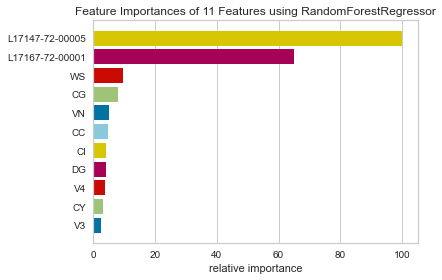

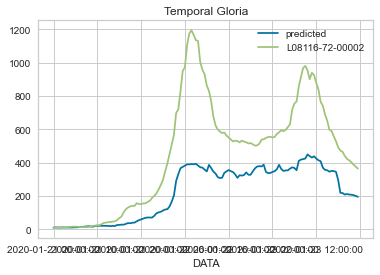

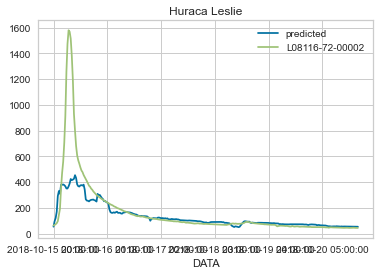

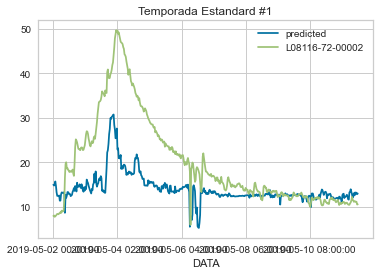

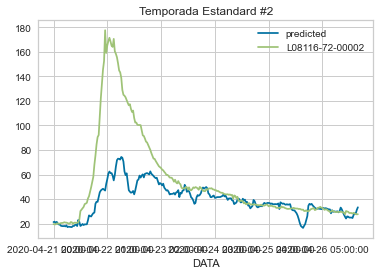

Iteració:  2
CPU times: user 2.53 s, sys: 55.1 ms, total: 2.58 s
Wall time: 21.7 s


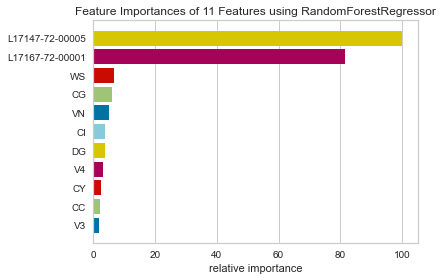

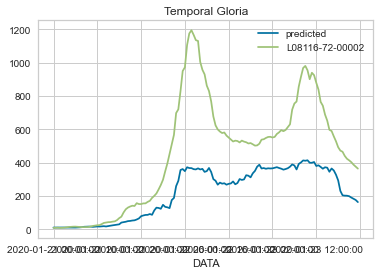

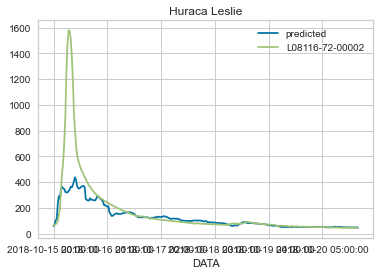

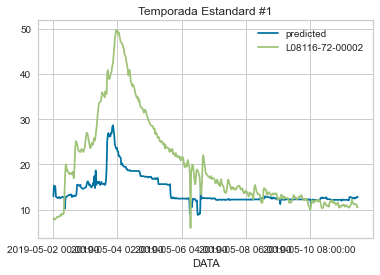

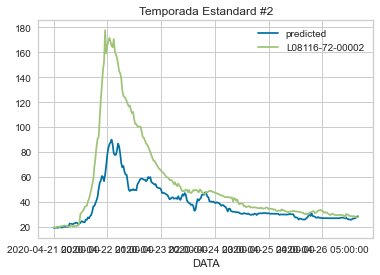

Iteració:  3
CPU times: user 3.71 s, sys: 70.8 ms, total: 3.78 s
Wall time: 31.6 s


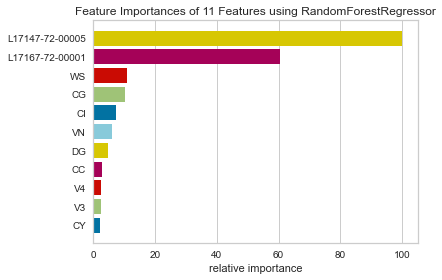

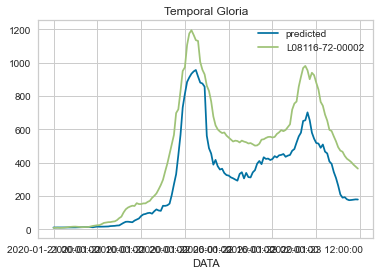

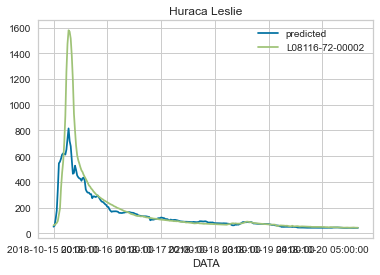

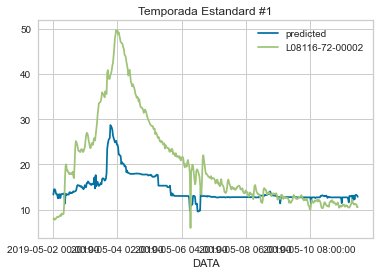

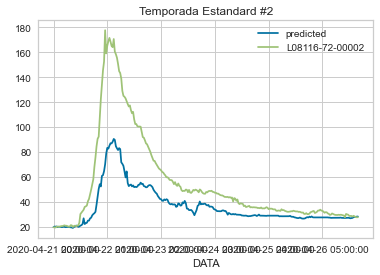

Time:  0:01:13.779036


In [145]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]

    model = RandomForestRegressor()
    tscv = TimeSeriesSplit()
    gsearch = HalvingGridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_AltX_train, Df_Alty_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_AltX_test, Df_Alty_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_AltX_test)
    rmseScore = mean_squared_error(Df_Alty_test, predicty, squared=False)
    
    nameh = Df_AltX.columns[0]
    hores = "1 day"
   
    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_AltX, Df_Alty)
    viz.show()
    
    plotYtestAnomaly1 = dataPredictionsY["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = dataPredictionsY["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = dataPredictionsY["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = dataPredictionsY["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = dataPredictionsX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = dataPredictionsX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = dataPredictionsX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = dataPredictionsX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = gsearchfited.best_estimator_.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = gsearchfited.best_estimator_.predict(plotXtestAnomaly2.values)
    predictStandard1 = gsearchfited.best_estimator_.predict(plotXtestStandard1.values)
    predictStandard2 = gsearchfited.best_estimator_.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'Random Forest','RMSE Total':rmseScore, 'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

# XGBoost (Alt Ter)

Iteració:  1
[11:04:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: user 4.08 s, sys: 1.48 s, total: 5.56 s
Wall time: 10.7 s


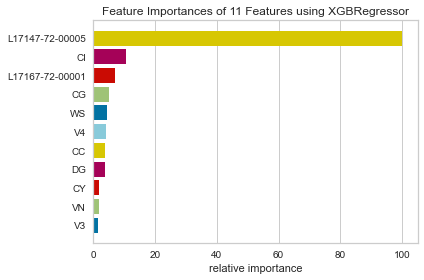

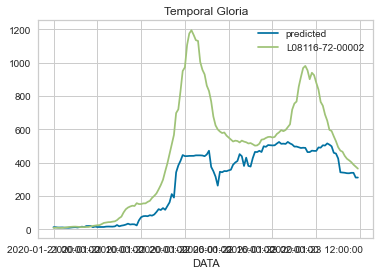

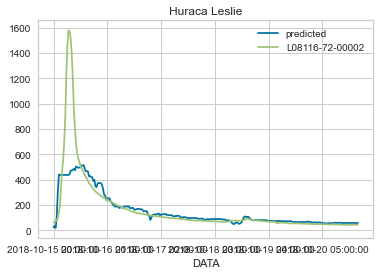

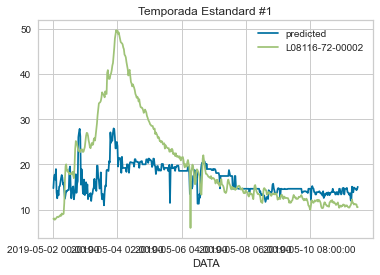

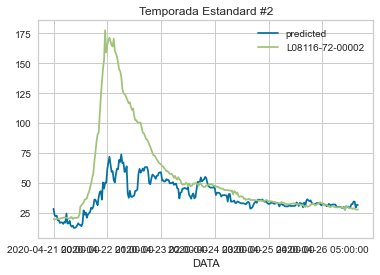

Iteració:  2
[11:03:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/b

[11:03:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.mac

[11:04:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.mac

[11:03:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.mac

[11:03:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.mac

[11:03:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.mac

[11:03:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.mac

[11:04:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.mac

CPU times: user 3.79 s, sys: 1.18 s, total: 4.97 s
Wall time: 32.4 s


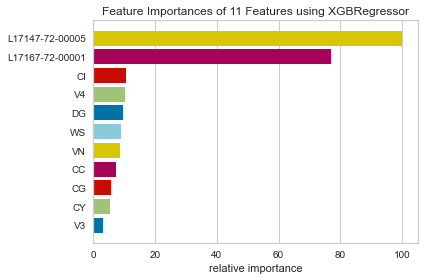

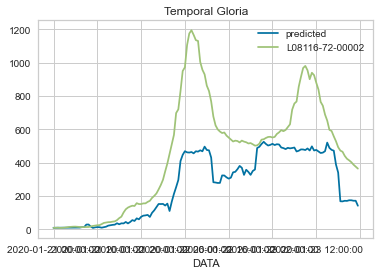

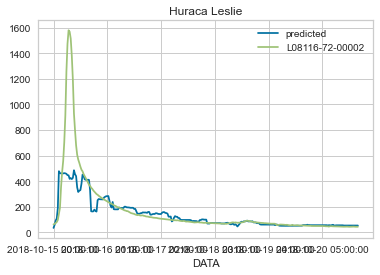

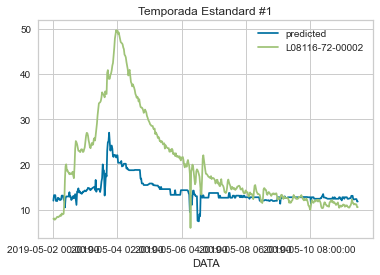

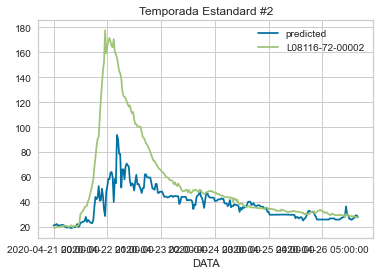

Iteració:  3
[11:04:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/b

[11:04:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.mac

[11:04:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.mac

[11:04:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.mac

[11:04:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.mac

[11:04:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.mac

[11:04:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:04:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.mac

[11:05:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: user 27.3 s, sys: 9.05 s, total: 36.3 s
Wall time: 38.8 s


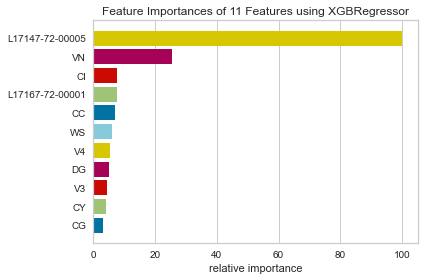

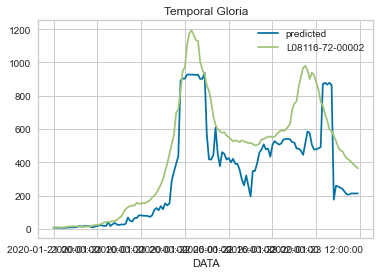

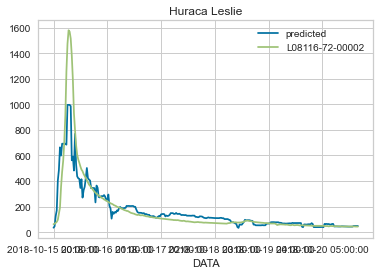

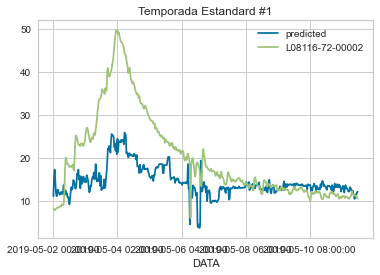

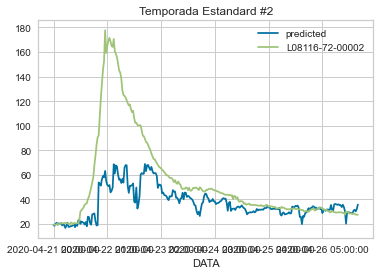

Time:  0:01:23.072425


In [146]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]

    model = xgb.XGBRegressor()
    tscv = TimeSeriesSplit()
    gsearch = HalvingGridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_AltX_train, Df_Alty_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_AltX_test, Df_Alty_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_AltX_test)
    rmseScore = mean_squared_error(Df_Alty_test, predicty, squared=False)
    
    nameh = Df_AltX.columns[0]
    hores = "1 day"

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_AltX, Df_Alty)
    viz.show()
    
    plotYtestAnomaly1 = dataPredictionsY["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = dataPredictionsY["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = dataPredictionsY["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = dataPredictionsY["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = dataPredictionsX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = dataPredictionsX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = dataPredictionsX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = dataPredictionsX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    
    predictAnomaly1 = gsearchfited.best_estimator_.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = gsearchfited.best_estimator_.predict(plotXtestAnomaly2.values)
    predictStandard1 = gsearchfited.best_estimator_.predict(plotXtestStandard1.values)
    predictStandard2 = gsearchfited.best_estimator_.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)

    new_row = {'Method':'XGBoost','RMSE Total':rmseScore, 'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()
    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

## LightGBM (Alt Ter)

2012-01-01 23:00:00


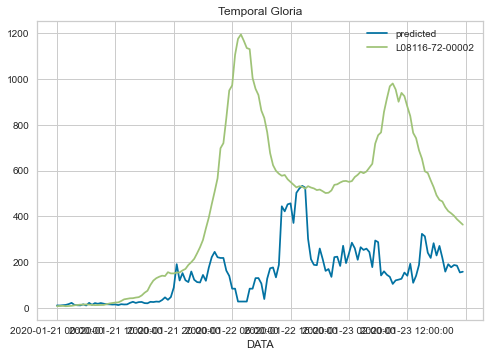

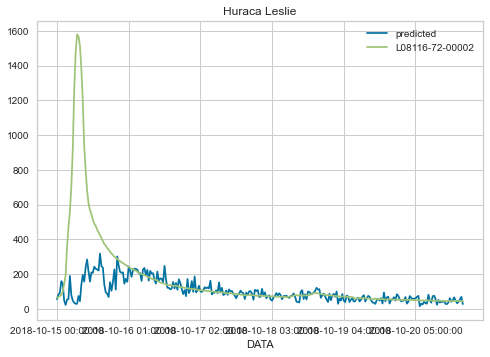

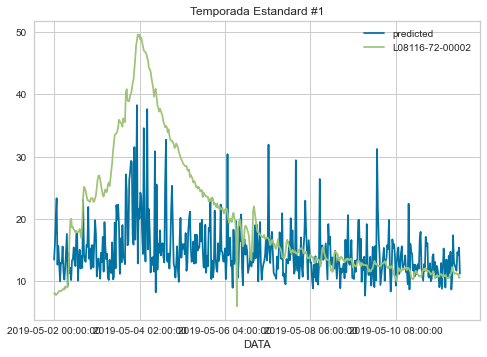

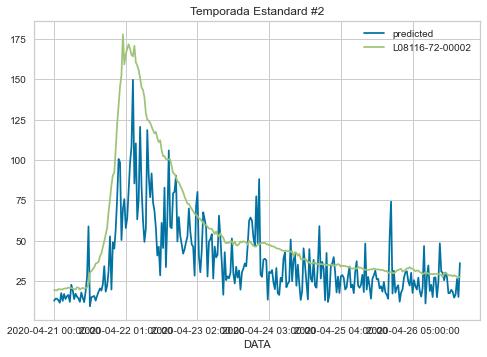

2015-01-01 15:30:00


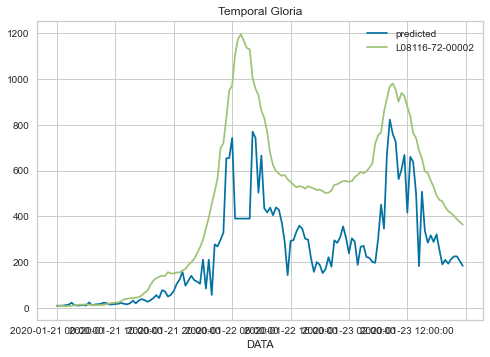

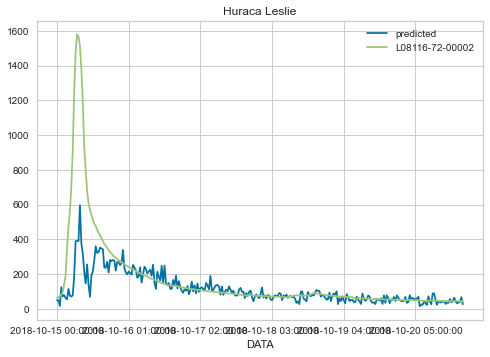

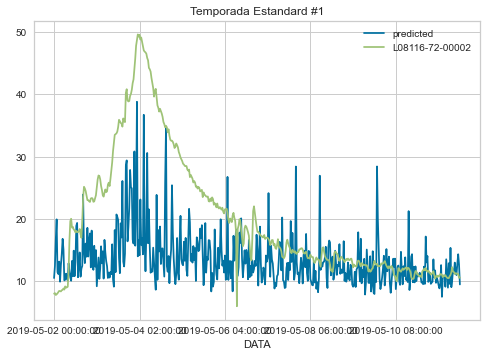

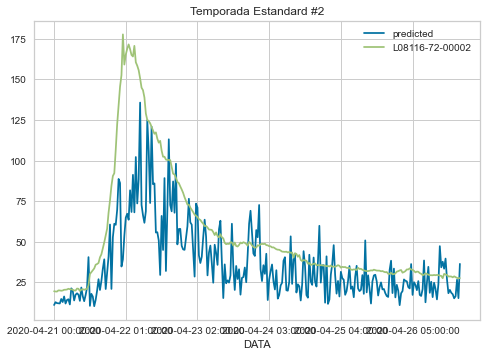

2018-01-01 08:00:00


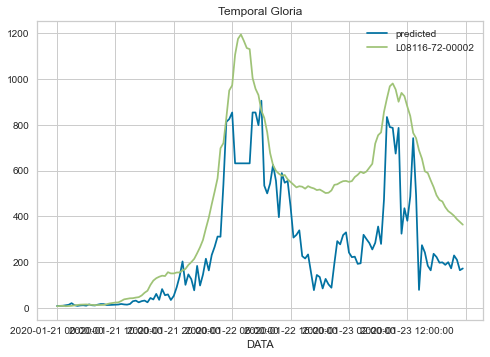

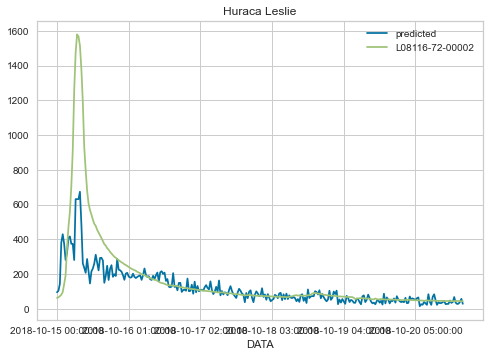

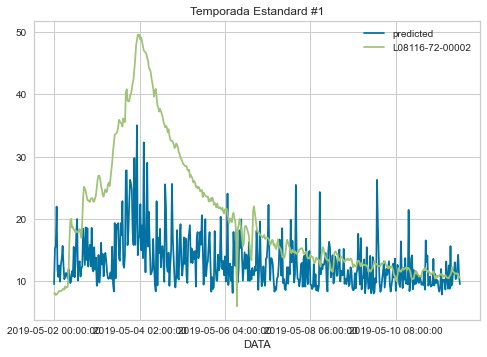

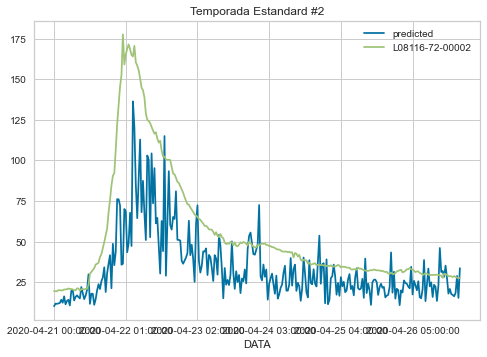

Time:  0:01:56.827356


In [52]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}


iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]
    
    print(Df_AltX.iloc[test_index].index[0])

    model = lgb.LGBMRegressor(first_metric_only = True, **param_search)
    
    model.fit(Df_AltX_train, Df_Alty_train,
          eval_metric = 'l1', 
          eval_set = [(Df_AltX_test, Df_Alty_test)],
          #early_stopping_rounds = 10,
          verbose = 0)
    predicty = model.predict(Df_AltX_test)
    rmseScore = mean_squared_error(Df_Alty_test, predicty, squared=False)
    
    nameh = Df_AltX.columns[0]
    hores = "1 day"
    
    
    
    #joblib.dump(gsearchfited.best_estimator_, 'resultsDf/pickle/partAlta/XGBoost_'+str(df_results_altTer.index[-1])+'.pkl', compress = 1)

    #viz = FeatureImportances(gsearchfited.best_estimator_)
    #viz.fit(Df_AltX, Df_Alty)
    #viz.show()
    
    plotYtestAnomaly1 = dataPredictionsY["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = dataPredictionsY["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = dataPredictionsY["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = dataPredictionsY["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = dataPredictionsX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = dataPredictionsX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = dataPredictionsX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = dataPredictionsX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = model.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = model.predict(plotXtestAnomaly2.values)
    predictStandard1 = model.predict(plotXtestStandard1.values)
    predictStandard2 = model.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'LightGBM','RMSE Total':rmseScore,'Score':None,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

# ExtraTrees (Alt Ter)

Iteració:  1
CPU times: user 267 ms, sys: 116 ms, total: 382 ms
Wall time: 3.32 s


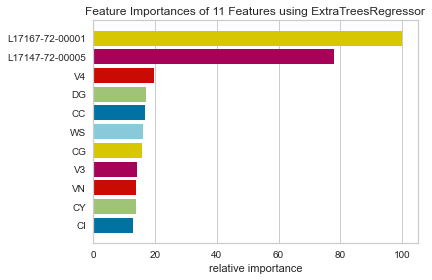

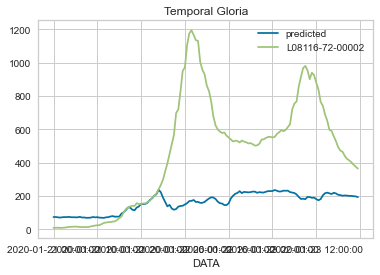

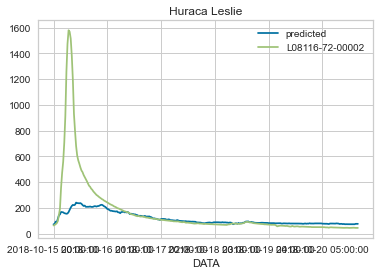

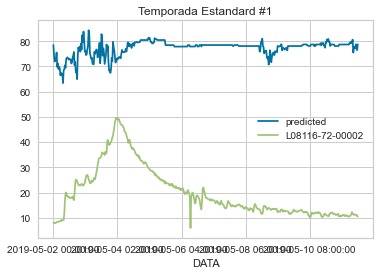

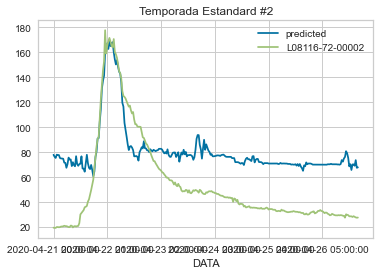

IndexError: index 6205 is out of bounds for axis 0 with size 6205

In [313]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]

    model = ExtraTreesRegressor()
    tscv = TimeSeriesSplit()
    gsearch = HalvingGridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_AltX_train, Df_Alty_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_AltX_test, Df_Alty_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_AltX_test)
    rmseScore = mean_squared_error(Df_Alty_test, predicty, squared=False)
    
    nameh = Df_AltX.columns[0]
    hores = "1 day"
    
   
    

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_AltX, Df_Alty)
    viz.show()
    
    plotYtestAnomaly1 = dataPredictionsY["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = dataPredictionsY["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = dataPredictionsY["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = dataPredictionsY["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = dataPredictionsX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = dataPredictionsX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = dataPredictionsX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = dataPredictionsX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = gsearchfited.best_estimator_.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = gsearchfited.best_estimator_.predict(plotXtestAnomaly2.values)
    predictStandard1 = gsearchfited.best_estimator_.predict(plotXtestStandard1.values)
    predictStandard2 = gsearchfited.best_estimator_.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'Extra Trees','RMSE Total':rmseScore, 'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

# Linear Regression (Alt Ter)

Iteració:  1
CPU times: user 1.49 ms, sys: 1.58 ms, total: 3.07 ms
Wall time: 2.05 ms


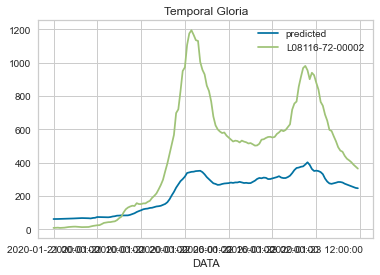

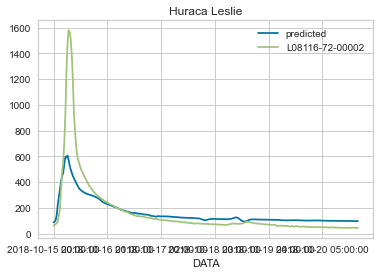

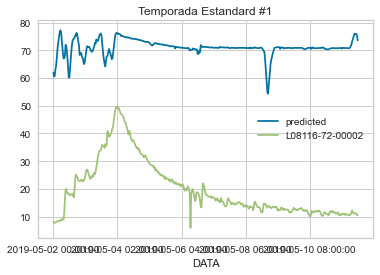

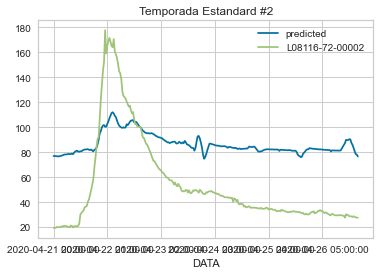

IndexError: index 6205 is out of bounds for axis 0 with size 6205

In [314]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]

    model = LinearRegression()
    print("Iteració: ", iteracio)
    %time modelfited = model.fit(Df_AltX_train, Df_Alty_train)
        
    score = modelfited.score(Df_AltX_test, Df_Alty_test)
    
    predicty = modelfited.predict(Df_AltX_test)
    rmseScore = mean_squared_error(Df_Alty_test, predicty, squared=False)
    

    hores = "1 day"
    
    
    
    #joblib.dump(modelfited, 'resultsDf/pickle/partAlta/LinearRegression_'+str(df_results_altTer.index[-1])+'.pkl', compress = 1)
    
    plotYtestAnomaly1 = dataPredictionsY["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = dataPredictionsY["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = dataPredictionsY["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = dataPredictionsY["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = dataPredictionsX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = dataPredictionsX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = dataPredictionsX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = dataPredictionsX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = modelfited.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = modelfited.predict(plotXtestAnomaly2.values)
    predictStandard1 = modelfited.predict(plotXtestStandard1.values)
    predictStandard2 = modelfited.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'Linear Regression','RMSE Total':rmseScore, 'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [302]:
df_results_altTer

Method     Score Prediccio_Hores  RMSE Total  RMSE_Leslie  \
0        Extra Trees   0.55669           1 day  174.552731   172.938907   
1        Extra Trees  0.938483           1 day   35.334433    36.420481   
2        Extra Trees  0.977893           1 day   31.438520    36.991550   
3  Linear Regression  0.747773           1 day  131.664439   120.841281   
4  Linear Regression  0.734899           1 day   73.351317   101.576749   
5  Linear Regression  0.840224           1 day   84.518018   101.529676   

   RMSE_Standard1  RMSE_Standard2  RSME_Gloria  
0       58.620625       32.005157   274.181219  
1        8.234487       12.156688    51.840106  
2        7.379253       10.801804    54.307299  
3       22.967737       26.770751   220.314989  
4       34.786903       30.362365   142.878812  
5       29.293080       28.018232   157.368175

# Models Baix Ter

# Random Forest (Baix Ter)

In [57]:
df_results_baixTer = pd.DataFrame(columns = ["Method","Score","RMSE_Score","Prediccio_Hores"])

Iteració:  1
CPU times: total: 15.6 s
Wall time: 47.5 s


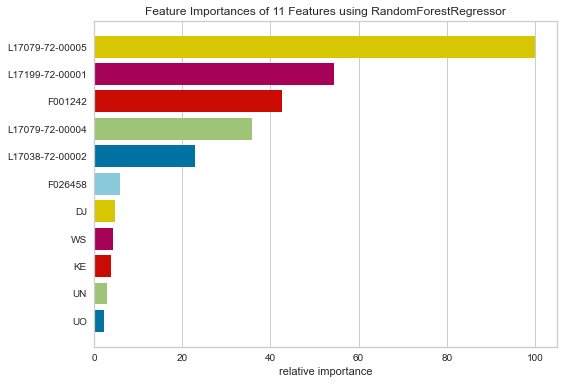

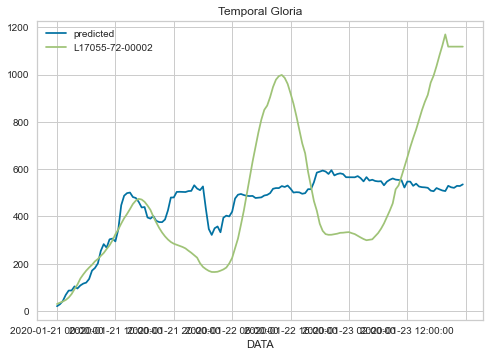

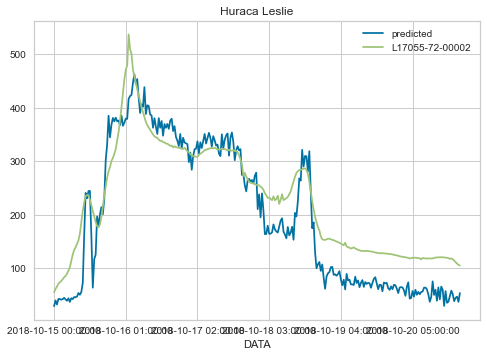

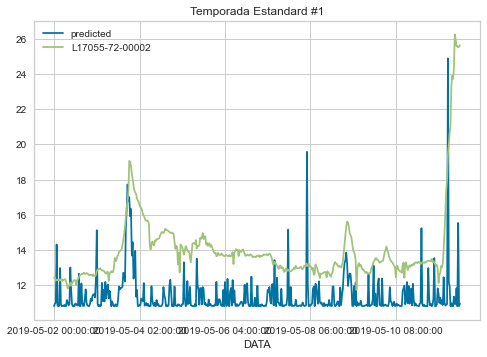

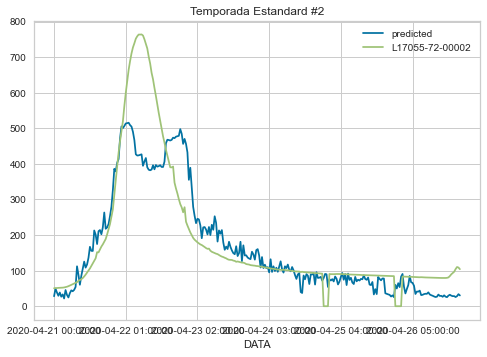

Iteració:  2
CPU times: total: 3.58 s
Wall time: 38.7 s


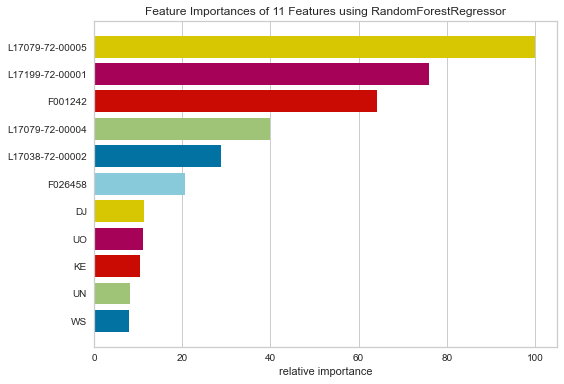

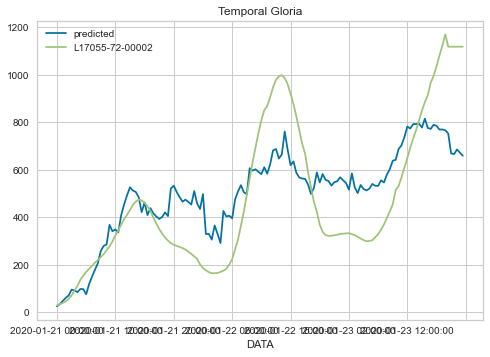

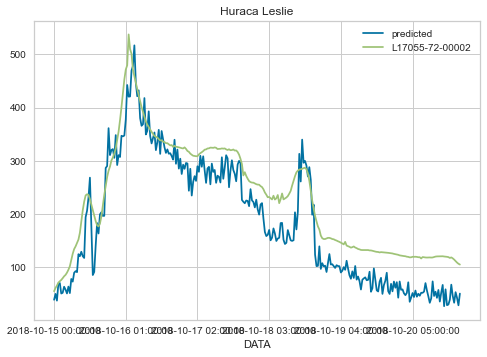

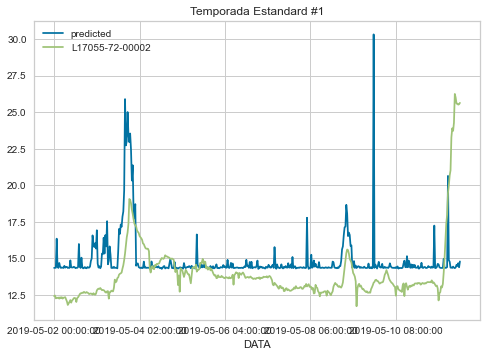

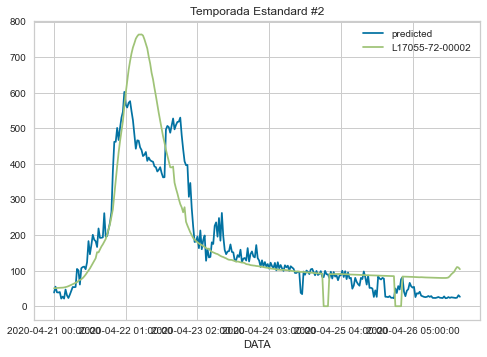

Iteració:  3
CPU times: total: 33.2 s
Wall time: 2min 19s


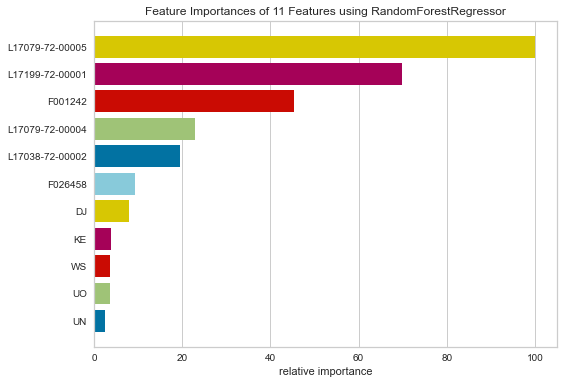

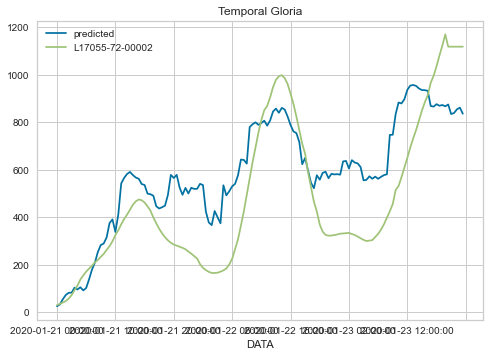

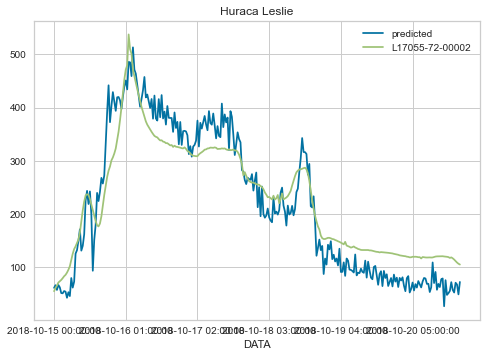

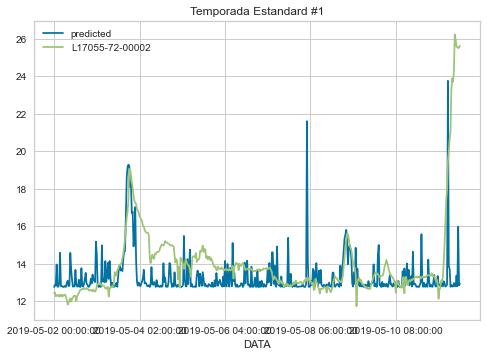

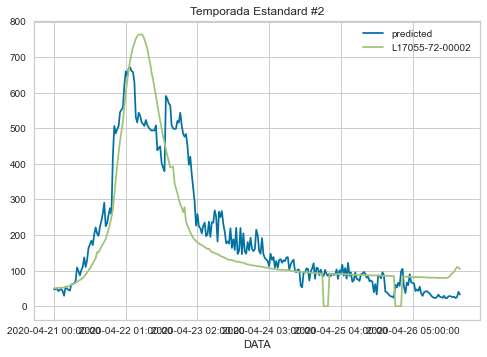

Time:  0:03:48.067290


In [58]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_BaixX):
    iteracio += 1
    Df_BaixX_train, Df_BaixX_test = Df_BaixX.values[train_index], Df_BaixX.values[test_index]
    Df_Baixy_train, Df_Baixy_test = Df_Baixy.values.ravel()[train_index], Df_Baixy.values.ravel()[test_index]

    model = RandomForestRegressor()
    tscv = TimeSeriesSplit()
    gsearch = HalvingGridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_BaixX_train, Df_Baixy_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_BaixX_test, Df_Baixy_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_BaixX_test)
    rmseScore = mean_squared_error(Df_Baixy_test, predicty, squared=False)
    
    nameh = Df_BaixX.columns[0]
    hores = "1 day"

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_BaixX, Df_Baixy)
    viz.show()
    
    plotYtestAnomaly1 = dataPredictionsY["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = dataPredictionsY["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = dataPredictionsY["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = dataPredictionsY["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = dataPredictionsX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = dataPredictionsX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = dataPredictionsX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = dataPredictionsX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = gsearchfited.best_estimator_.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = gsearchfited.best_estimator_.predict(plotXtestAnomaly2.values)
    predictStandard1 = gsearchfited.best_estimator_.predict(plotXtestStandard1.values)
    predictStandard2 = gsearchfited.best_estimator_.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'Random Forest','RMSE Total':rmseScore, 'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

# XGBoost (Baix Ter)

Iteració:  1
[00:31:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 18.1 s
Wall time: 32.7 s


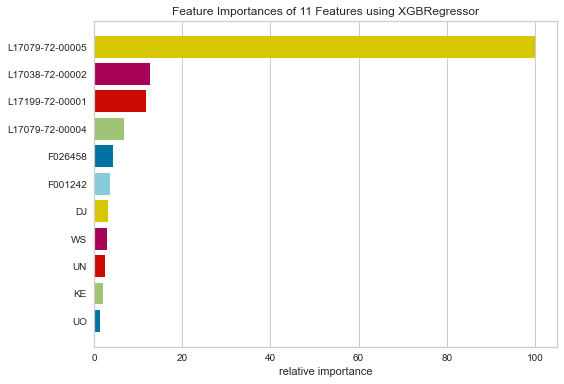

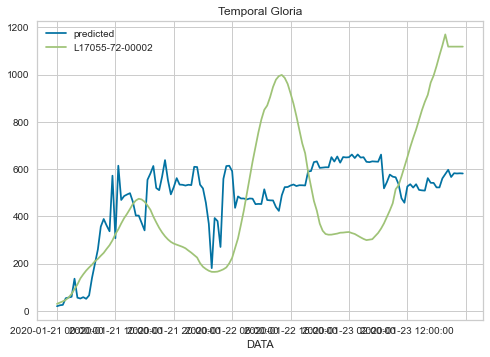

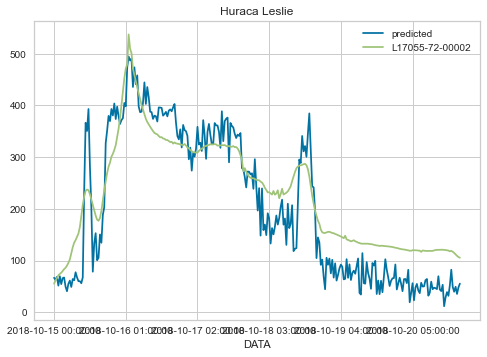

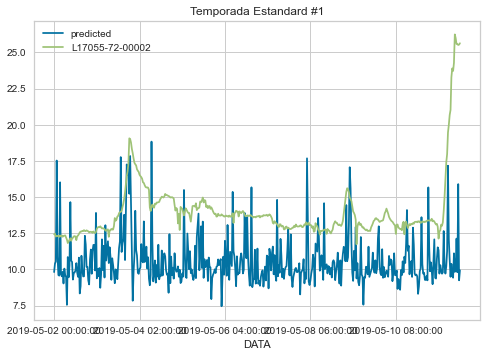

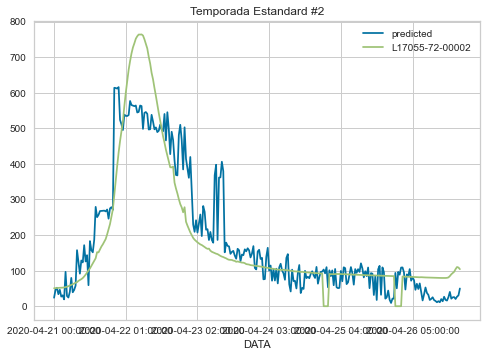

Iteració:  2
[00:32:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 20.9 s
Wall time: 44.4 s


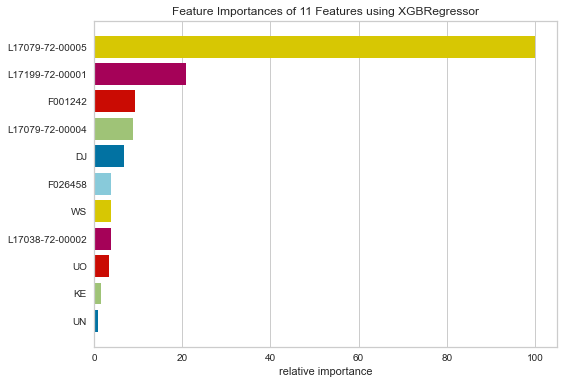

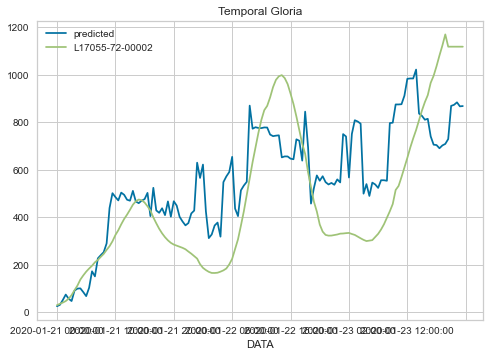

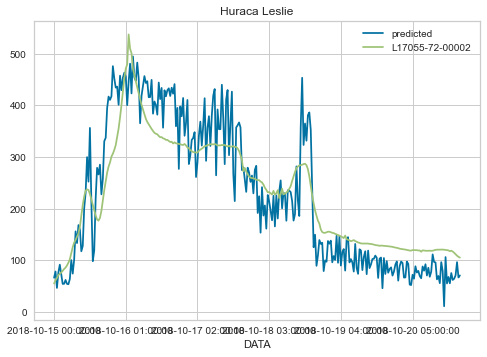

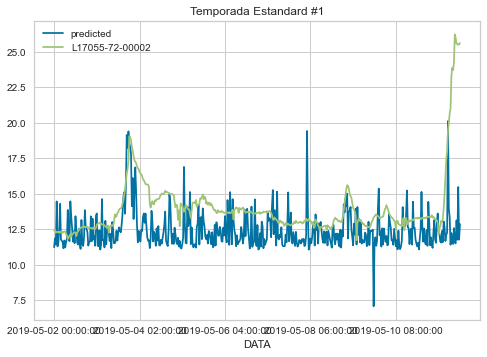

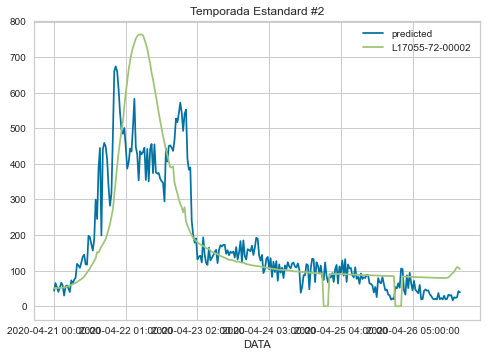

Iteració:  3
[00:34:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 58.5 s
Wall time: 1min 54s


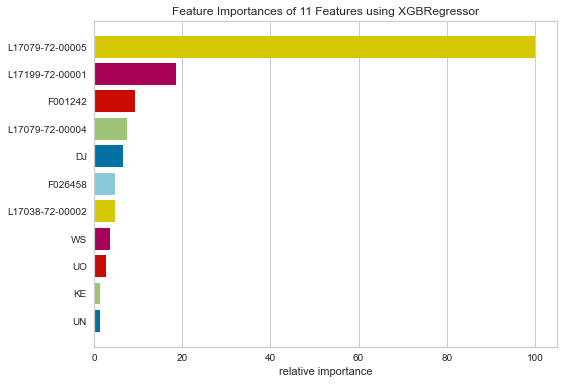

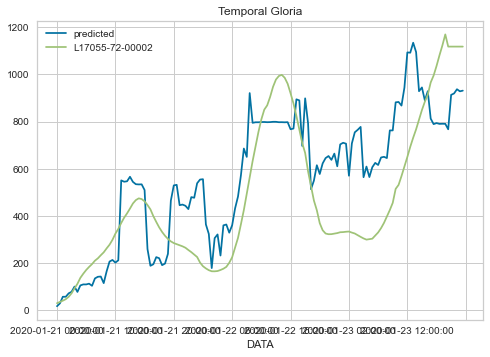

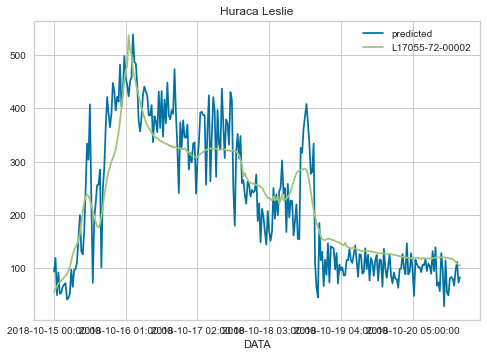

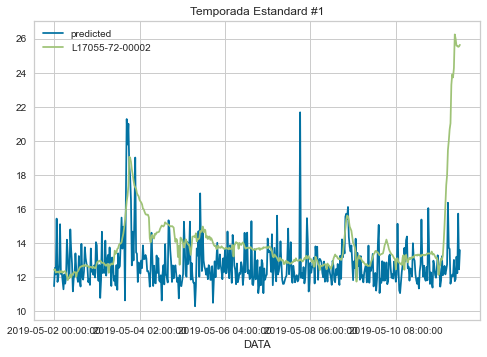

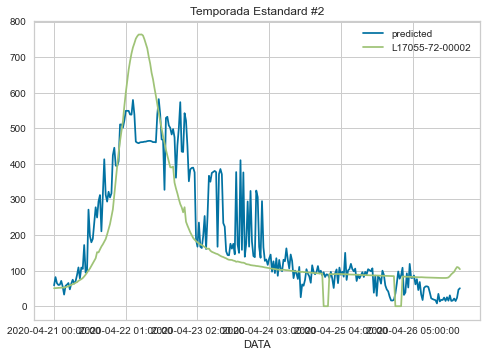

Time:  0:03:12.863968


In [59]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_BaixX):
    iteracio += 1
    Df_BaixX_train, Df_BaixX_test = Df_BaixX.values[train_index], Df_BaixX.values[test_index]
    Df_Baixy_train, Df_Baixy_test = Df_Baixy.values.ravel()[train_index], Df_Baixy.values.ravel()[test_index]

    model = xgb.XGBRegressor()
    tscv = TimeSeriesSplit()
    gsearch = HalvingGridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_BaixX_train, Df_Baixy_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_BaixX_test, Df_Baixy_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_BaixX_test)
    rmseScore = mean_squared_error(Df_Baixy_test, predicty, squared=False)
    
    nameh = Df_BaixX.columns[0]
    hores = "1 day"
    

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_BaixX, Df_Baixy)
    viz.show()
    
    plotYtestAnomaly1 = dataPredictionsY["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = dataPredictionsY["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = dataPredictionsY["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = dataPredictionsY["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = dataPredictionsX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = dataPredictionsX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = dataPredictionsX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = dataPredictionsX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = gsearchfited.best_estimator_.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = gsearchfited.best_estimator_.predict(plotXtestAnomaly2.values)
    predictStandard1 = gsearchfited.best_estimator_.predict(plotXtestStandard1.values)
    predictStandard2 = gsearchfited.best_estimator_.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'XGBoost','RMSE Total':rmseScore,'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()


    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

## LightGBM (Baix Ter)

2012-01-01 23:00:00


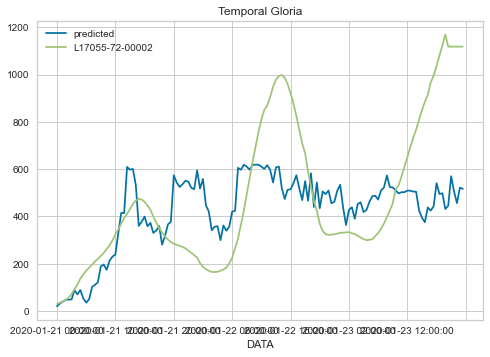

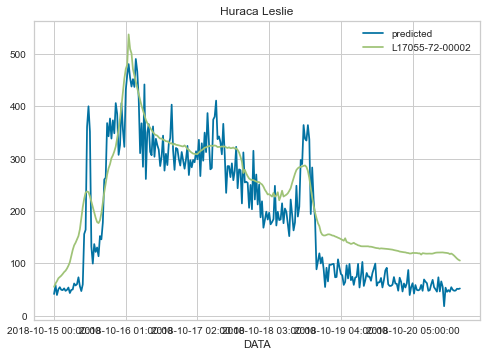

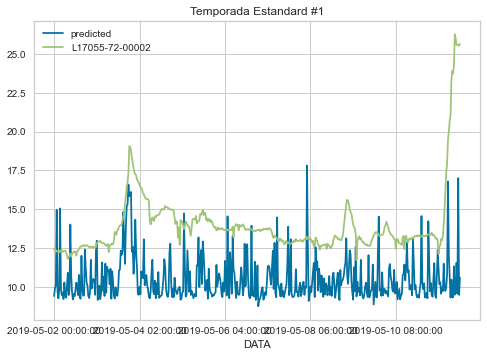

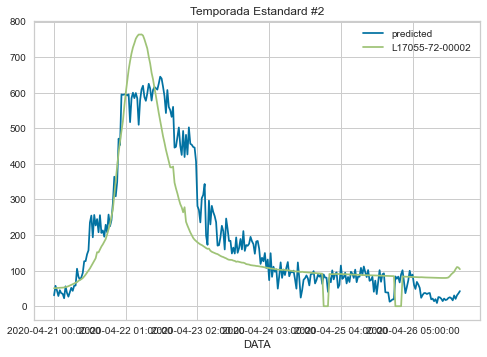

2015-01-01 15:30:00


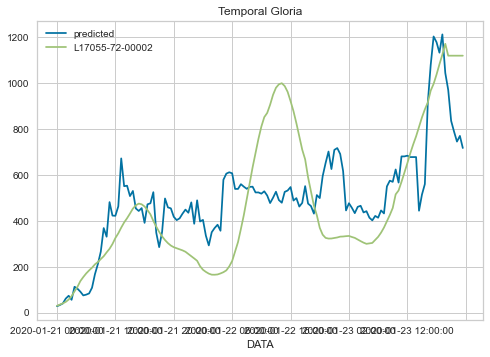

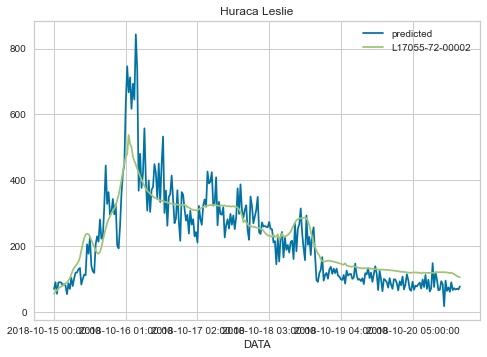

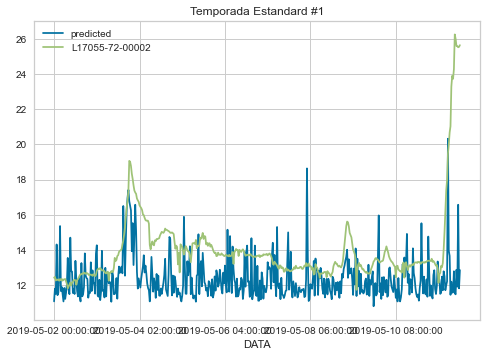

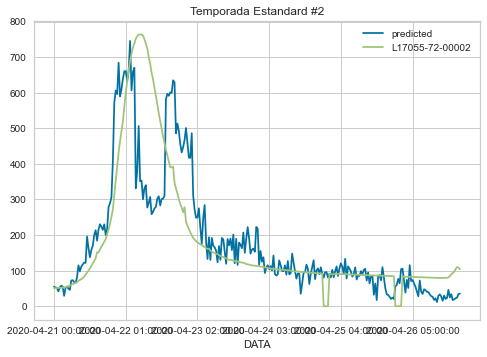

2018-01-01 08:00:00


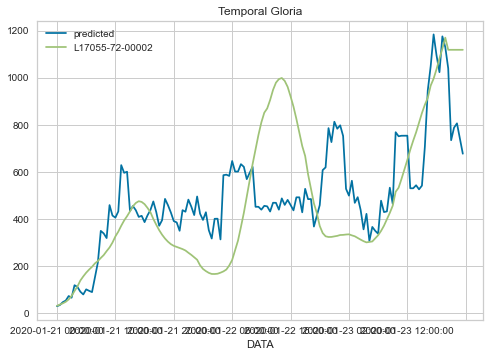

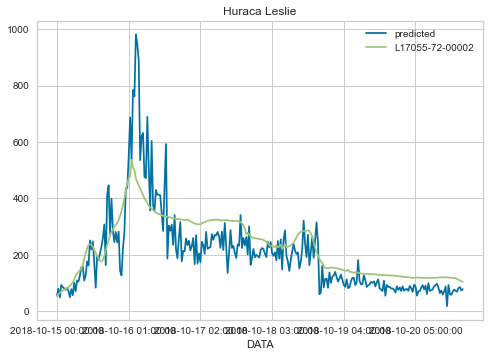

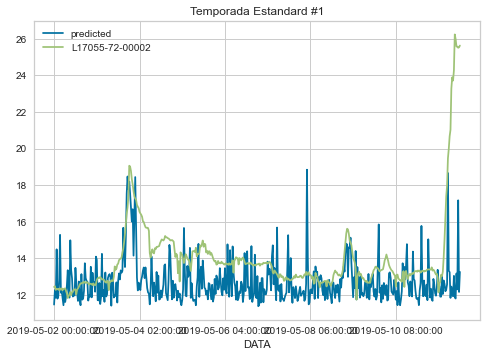

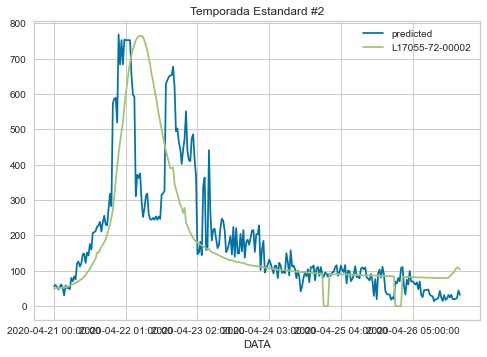

Time:  0:01:55.206242


In [60]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}

#Calcular només amb els valors on plou


iteracio = 0
for train_index, test_index in tscv.split(Df_BaixX):
    iteracio += 1
    Df_BaixX_train, Df_BaixX_test = Df_BaixX.values[train_index], Df_BaixX.values[test_index]
    Df_Baixy_train, Df_Baixy_test = Df_Baixy.values.ravel()[train_index], Df_Baixy.values.ravel()[test_index]
    
    print(Df_BaixX.iloc[test_index].index[0])

    model = lgb.LGBMRegressor(first_metric_only = True, **param_search)
    
    model.fit(Df_BaixX_train, Df_Baixy_train,
          eval_metric = 'l1', 
          eval_set = [(Df_BaixX_test, Df_Baixy_test)],
          #early_stopping_rounds = 10,
          verbose = 0)
    predicty = model.predict(Df_BaixX_test)
    rmseScore = mean_squared_error(Df_Baixy_test, predicty, squared=False)
    
    nameh = Df_BaixX.columns[0]
    hores = "1 day"
    
    
    
    #joblib.dump(gsearchfited.best_estimator_, 'resultsDf/pickle/partBaixa/XGBoost_'+str(df_results_BaixTer.index[-1])+'.pkl', compress = 1)

    #viz = FeatureImportances(gsearchfited.best_estimator_)
    #viz.fit(Df_BaixX, Df_Baixy)
    #viz.show()
    
    plotYtestAnomaly1 = dataPredictionsY["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = dataPredictionsY["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = dataPredictionsY["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = dataPredictionsY["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = dataPredictionsX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = dataPredictionsX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = dataPredictionsX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = dataPredictionsX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = model.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = model.predict(plotXtestAnomaly2.values)
    predictStandard1 = model.predict(plotXtestStandard1.values)
    predictStandard2 = model.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'LightGBM','RMSE Total':rmseScore,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

# ExtraTrees (Baix Ter)

Iteració:  1
CPU times: total: 2.06 s
Wall time: 10.9 s


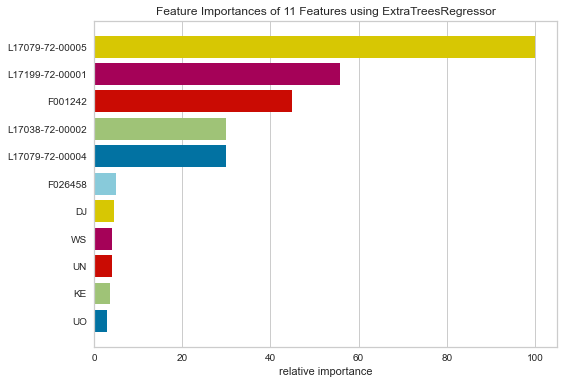

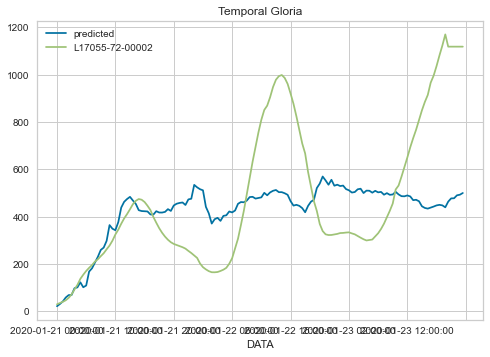

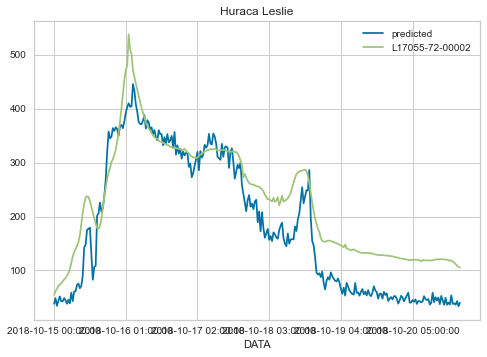

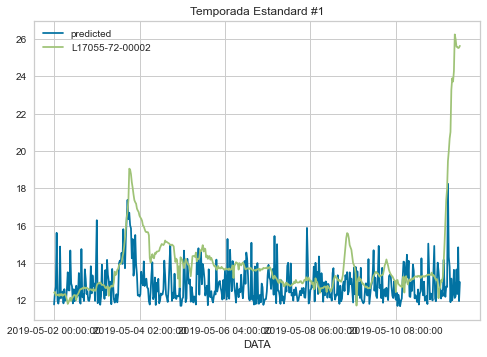

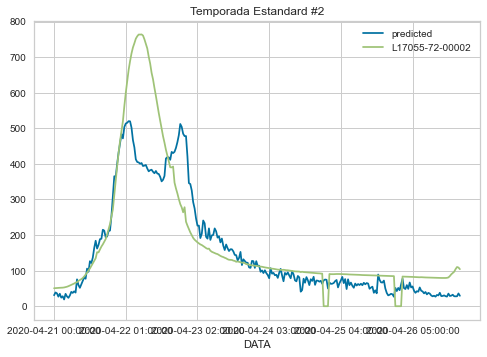

Iteració:  2
CPU times: total: 1.75 s
Wall time: 11.1 s


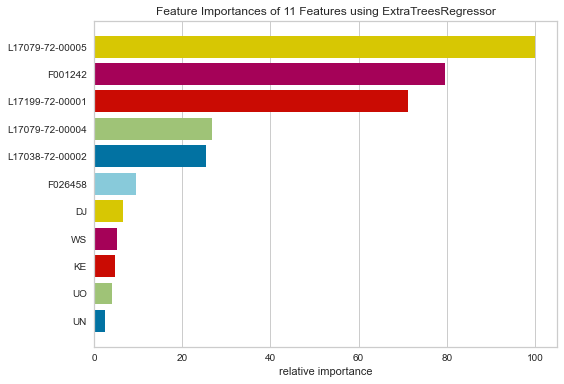

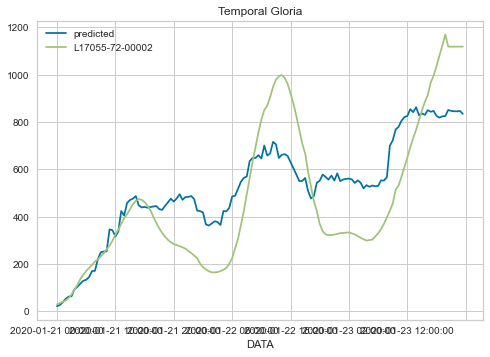

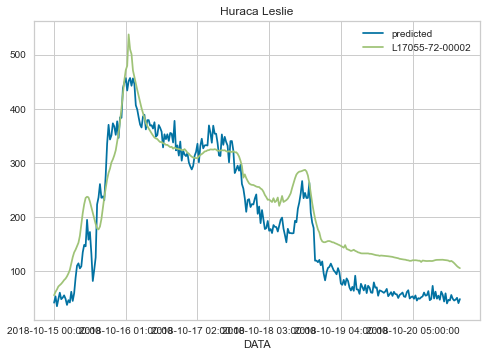

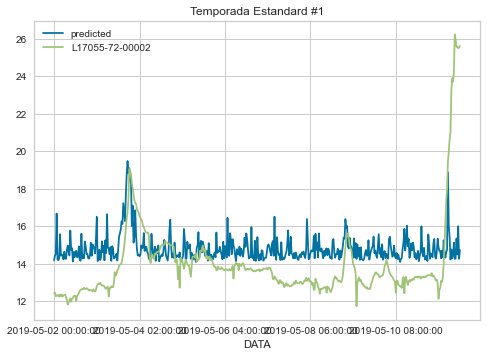

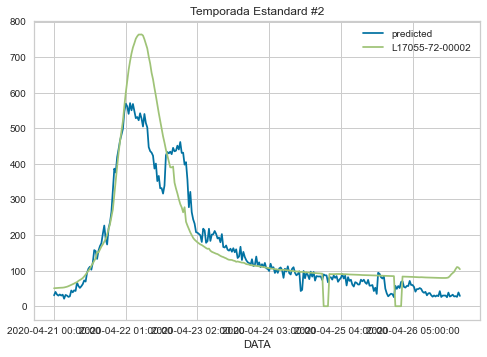

Iteració:  3
CPU times: total: 7.3 s
Wall time: 47.3 s


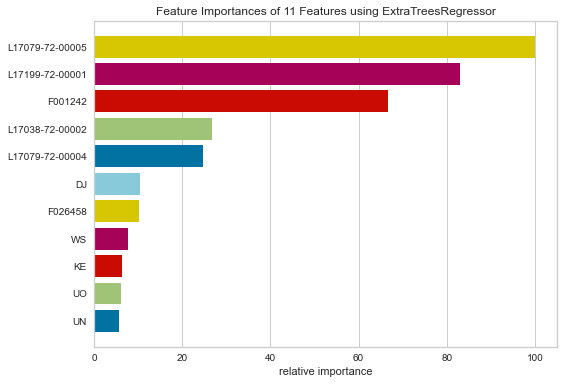

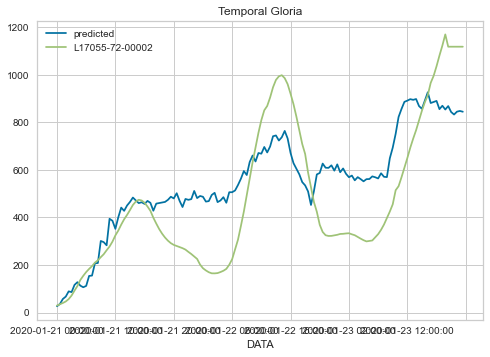

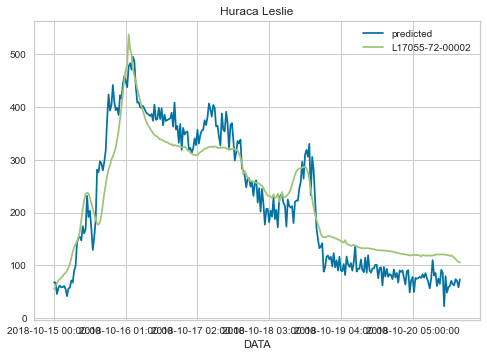

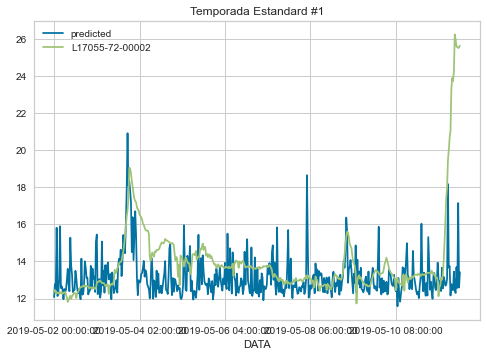

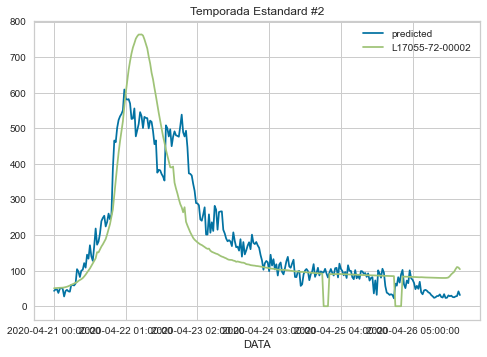

Time:  0:01:12.738060


In [61]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_BaixX):
    iteracio += 1
    Df_BaixX_train, Df_BaixX_test = Df_BaixX.values[train_index], Df_BaixX.values[test_index]
    Df_Baixy_train, Df_Baixy_test = Df_Baixy.values.ravel()[train_index], Df_Baixy.values.ravel()[test_index]

    model = ExtraTreesRegressor()
    tscv = TimeSeriesSplit()
    gsearch = HalvingGridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_BaixX_train, Df_Baixy_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_BaixX_test, Df_Baixy_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_BaixX_test)
    rmseScore = mean_squared_error(Df_Baixy_test, predicty, squared=False)
    
    nameh = Df_BaixX.columns[0]
    hores = "1 day"
    
    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_BaixX, Df_Baixy)
    viz.show()
    
    plotYtestAnomaly1 = dataPredictionsY["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = dataPredictionsY["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = dataPredictionsY["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = dataPredictionsY["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = dataPredictionsX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = dataPredictionsX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = dataPredictionsX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = dataPredictionsX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = gsearchfited.best_estimator_.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = gsearchfited.best_estimator_.predict(plotXtestAnomaly2.values)
    predictStandard1 = gsearchfited.best_estimator_.predict(plotXtestStandard1.values)
    predictStandard2 = gsearchfited.best_estimator_.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'ExtraTrees','RMSE Total':rmseScore,'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()


    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

# Linear Regression (Baix Ter)

In [155]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_BaixX):
    iteracio += 1
    Df_BaixX_train, Df_BaixX_test = Df_BaixX.values[train_index], Df_BaixX.values[test_index]
    Df_Baixy_train, Df_Baixy_test = Df_Baixy.values.ravel()[train_index], Df_Baixy.values.ravel()[test_index]

    model = LinearRegression()
    print("Iteració: ", iteracio)
    %time modelfited = model.fit(Df_BaixX_train, Df_Baixy_train)
        
    score = modelfited.score(Df_BaixX_test, Df_Baixy_test)
    
    predicty = modelfited.predict(Df_BaixX_test)
    rmseScore = mean_squared_error(Df_Baixy_test, predicty, squared=False)
    

    hores = "1 day"
    
    plotYtestAnomaly1 = dataPredictionsY["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = dataPredictionsY["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = dataPredictionsY["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = dataPredictionsY["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = dataPredictionsX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = dataPredictionsX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = dataPredictionsX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = dataPredictionsX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = modelfited.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = modelfited.predict(plotXtestAnomaly2.values)
    predictStandard1 = modelfited.predict(plotXtestStandard1.values)
    predictStandard2 = modelfited.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'Linear Regression','RMSE Total':rmseScore,'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()


    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

Iteració:  1
CPU times: user 2.12 ms, sys: 1.03 ms, total: 3.15 ms
Wall time: 2.89 ms


AttributeError: 'LinearRegression' object has no attribute 'best_estimator_'

In [63]:
df_results_baixTer

Method     Score RMSE_Score Prediccio_Hores  RMSE Total  \
0       Random Forest  0.732572        NaN           1 day   17.910053   
1       Random Forest  0.358366        NaN           1 day    5.474118   
2       Random Forest  0.681821        NaN           1 day   32.364492   
3             XGBoost   0.68282        NaN           1 day   19.505015   
4             XGBoost  0.475184        NaN           1 day    4.950786   
5             XGBoost  0.654919        NaN           1 day   33.704932   
6          ExtraTrees  0.719929        NaN           1 day   18.328509   
7          ExtraTrees  0.405163        NaN           1 day    5.270716   
8          ExtraTrees   0.67582        NaN           1 day   32.668286   
9   Linear Regression  0.675835        NaN           1 day   19.718621   
10  Linear Regression -0.494881        NaN           1 day    8.355526   
11  Linear Regression  0.661081        NaN           1 day   33.402649   

    RMSE_Leslie  RMSE_Standard1  RMSE_Standard2  RSME_Gloria  
0     54.409785        3.375931       95.606456   265.135215  
1     54.182573        2.561396       91.477102   194.916731  
2     46.237031        2.253019       84.931268   202.333867  
3     60.819139        4.212844       85.998309   289.328904  
4     58.292891        2.719697      114.149487   223.742174  
5     56.755648        2.600357      106.740556   221.072129  
6     60.298088        2.438551       97.205728   277.162085  
7     51.849562        2.257579       74.385966   184.872960  
8     45.319728        2.326074       85.229628   198.109588  
9     45.319728        2.326074       85.229628   198.109588  
10    45.319728        2.326074       85.229628   198.109588  
11    45.319728        2.326074       85.229628   198.109588